In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import copy
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import kendalltau

# Causal tree
from deconfounder.causal_tree import CausalTree

# Deconfounder
from deconfounder.deconfound_estimator import DeconfoundEstimator
# from deconfounder.deconfound_classifier import DeconfoundClassifier
from deconfounder.deconfound_classifier_tmf import DeconfoundClassifier
from deconfounder.deconfound_ranker import DeconfoundRanker

# Evaluation metrics
from metrics import MSE, causal_impact, auuc_score, uplift_curve



In [2]:
## Data generation functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class DataGenerator:

    def __init__(
        self, 
        n_features, 
        alpha_0=1.0,
        theta=1.0,
        avg_cate=0.0,
        noise_scale_c=0.0,
        noise_scale_y0=0.0,
        noise_scale_a=1.0,
        treatment_type='linear'
    ):
      
        self.n_features = n_features
        self.alpha_0 = alpha_0
        self.theta = theta
        self.avg_cate = avg_cate
        self.noise_scale_c = noise_scale_c
        self.noise_scale_y0 = noise_scale_y0
        self.noise_scale_a = noise_scale_a
        self.treatment_type = treatment_type
        

    def reset_params(
        self,         
        n_features, 
        alpha_0=1.0,
        theta=1.0,
        avg_cate=0.0,
        noise_scale_c=0.0,
        noise_scale_y0=0.0,
        noise_scale_a=1.0,
        treatment_type='linear'
    ):

        self.n_features = n_features
        self.alpha_0 = alpha_0
        self.theta = theta
        self.avg_cate = avg_cate
        self.noise_scale_c = noise_scale_c
        self.noise_scale_y0 = noise_scale_y0
        self.noise_scale_a = noise_scale_a
        self.treatment_type = treatment_type
        
    def reset_coef(self):
        '''
        Return:
            - beta: Coefficient of X for C.
            - alpha: Coeficient of U for X.
        '''
        k = self.n_features
        theta = self.theta
        
        # beta
        self.beta = np.random.uniform(-1, 1, size=k)  
        self.beta_0 = -np.sum(dg.beta) * 0.5 + self.avg_cate

        # alpha
        noise_scale_a = self.noise_scale_a
        noise_a = np.random.normal(0, noise_scale_a, size=k)
        self.alpha = theta * self.beta + (1-theta) * noise_a
        
        
    def control_outcome(self, u):
        
        mu_y0 = u * self.alpha_0
        
        return mu_y0
    
    def treatment_probability(self, u, is_exp=False):
        if is_exp:
            return 0.5
        
        elif self.treatment_type=='linear':
            p_t_u = u.copy()
        
        elif self.treatment_type=='quad':
            p_t_u = - 2.5 * (u - 0.6) ** 2 + 1
            
#         p_t_u = 1 - 1 / (1 + np.exp(a*(u-b)))   
#         p_t_u = - 3 * (u - 0.5) ** 2 + 0.9
#         p_t_u = - 2.5 * (u - 0.6) ** 2 + 1
            
        return p_t_u
           
    def cate(self, X):

        x_beta = np.squeeze(np.dot(X, self.beta[:, np.newaxis]))
        c = x_beta + self.beta_0
        return c
    
    def covariate(self, u):

        n = u.shape[0]
        k = self.n_features
        ua = np.dot((u-0.5)[:, np.newaxis], self.alpha[np.newaxis, :])
        p = sigmoid(ua)
        X = np.random.binomial(1, p=p, size=(n, k))
        return X

    def generate_data(self, n, is_exp=False):

        noise_scale_c = self.noise_scale_c
        noise_scale_y0 = self.noise_scale_y0

        # Unobserved confounder
        u = np.random.uniform(0, 1, size=n) 
        
        # Covariate
        X = self.covariate(u)

        # CATE
        c = self.cate(X)
        noise_c = np.random.normal(0, noise_scale_c, size=n)
        
        # treatment
        p_t_u = self.treatment_probability(u, is_exp)
        t = np.random.binomial(1, p=p_t_u, size=n)

        # control outcome
        mu_y0 = self.control_outcome(u)
        y0 = mu_y0 + np.random.normal(0, noise_scale_y0, size=n)
        
        # observed outcome
        y = y0 + t * (c + noise_c)

        return X, t, y, c, y0, mu_y0

    def estimate_bias(self, X, n_per_x=10000):
        '''
        The estimation is: 
        
        E(Y|T=1, X)-E(Y|T=0, X) = alpha_0 * (E(U|T=1,X)-E(U|T=0,X))+E(C|X), where
        
        E(U|T,X) = \sum_u u * P(U=u|T, X) 
        
        '''
        alpha = self.alpha
        alpha_0 = self.alpha_0
        if X.ndim == 1:
            X = X[np.new_axis, :]

        n = X.shape[0]
        bias = np.empty(n)

        u = np.linspace(0, 1, num=n_per_x)
        ua = np.dot((u-0.5)[:, np.newaxis], alpha[np.newaxis, :])
        p_x1_u = sigmoid(ua)   # P(x=1|u), (n, k)
        p_t_u = self.treatment_probability(u, is_exp=False)
        
        for i in range(n):
            
            x = X[i]

            p_x_u = np.prod(x * p_x1_u + (1-x) * (1-p_x1_u), axis=1)  # (n, )
            
            p_xtu = p_x_u * p_t_u
            p_xcu = p_x_u * (1-p_t_u)

            p_xt = np.sum(p_xtu) 
            p_xc = np.sum(p_xcu)

            u_p_xtu = np.sum(u * p_xtu)
            u_p_xcu = np.sum(u * p_xcu)

            bias[i] = alpha_0 * (u_p_xtu / p_xt - u_p_xcu / p_xc)

        return bias 


In [3]:
np.random.seed(42)

dg = DataGenerator(
        n_features=50, 
        alpha_0=50.0,
        theta=0.3,
        avg_cate=0.2,
        noise_scale_c=0.1,
        noise_scale_y0=1.0,
        noise_scale_a=1.0,
        treatment_type='linear'
)

dg.reset_coef()

In [4]:
## Test data (experimental data)

n_test = 10000
X_test, t_test, y_test, c_test, y0_test, mu_y0_test = dg.generate_data(n_test, is_exp=True)

Scoring model: Learns a causal tree from the observational data

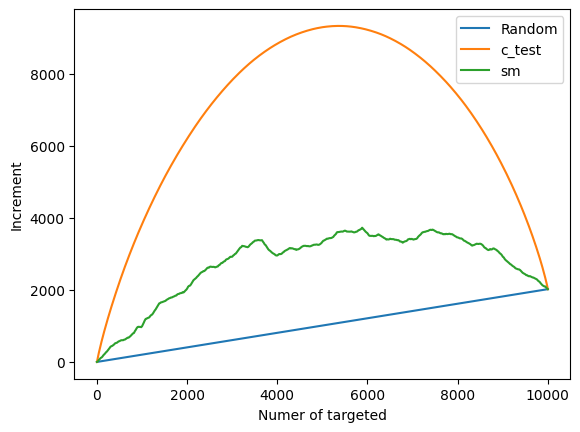

In [5]:
def scoring_model(dg, n):

    X_obs, t_obs, y_obs, c_obs, y0_obs, mu_y0_obs = dg.generate_data(n, is_exp=False)
    
    # # Causal tree on confounded data
    sm = CausalTree(random_state=42, min_samples_leaf=400)
    sm.fit(X_obs, np.c_[t_obs, y_obs])

    return sm

def plot_uplift_curves(cate, scores_dict, n_bins=500):

    n = cate.shape[0]
    cate = np.array(cate)
    ate = cate.mean()
    plt.plot([0, n], [0, ate*n], label='Random')

    for label, scores in scores_dict.items():
        curve_values = uplift_curve(cate, scores, n_bins)
        plt.plot(curve_values[0], curve_values[1], label=label)

    plt.xlabel('Numer of targeted')
    plt.ylabel("Increment")
    plt.legend()
    plt.show()

sm = scoring_model(dg, n=50000)

scores_dict = {'c_test': c_test, 'sm': sm.predict(X_test)}
plot_uplift_curves(c_test, scores_dict)


Deconfounders:
   * EE model with a single split;
   * EC model with a single split;
   * EE model with the split selected by EC, denoted as "EE_C"
   
Below is a small example showing the difference in splitting of these models

In [6]:
def fit_deconfounder(X, t, y, scores, method):
    if method == 'EE':
        dm = DeconfoundEstimator(max_depth=1)
    elif method == 'EC':
        dm = DeconfoundClassifier(max_depth=1)

    dm.fit(X, np.c_[t, y, scores])
    return dm

X, t, y, c, y0, _ = dg.generate_data(n=128, is_exp=True)
scores = sm.predict(X)

fnames = [f"x{i}" for i in range(50)]

ee = fit_deconfounder(X, t, y, scores, 'EE')
print('EE tree')
print(export_text(ee, feature_names=fnames))

ec = fit_deconfounder(X, t, y, scores, 'EC')
print('EC tree')
print(export_text(ec, feature_names=fnames))

split_feat = ec.tree_.feature[0]
mask = (X[:, split_feat] == 1)
X_m = 1 * mask[:, np.newaxis]
ee_c = fit_deconfounder(X_m, t, y, scores, 'EE')
print('EE_C tree')
print(export_text(ee_c, feature_names=[f"x{split_feat}"]))

EE tree
|--- x29 <= 0.50
|   |--- value: [10.66]
|--- x29 >  0.50
|   |--- value: [21.82]

EC tree
|--- x49 <= 0.50
|   |--- value: [16.62]
|--- x49 >  0.50
|   |--- value: [19.14]

EE_C tree
|--- x49 <= 0.50
|   |--- value: [12.79]
|--- x49 >  0.50
|   |--- value: [19.42]



In [7]:
def calc_tan(x):
    return np.tan(x-2)

def get_impurity(model):
    if model.get_depth() == 0:
        impurity = model.tree_.impurity[0]
    else:
        p_left = model.tree_.n_node_samples[1] / model.tree_.n_node_samples[0]
        impurity = p_left * calc_tan(model.tree_.impurity[1]) + \
            (1-p_left) * calc_tan(model.tree_.impurity[2]) 

    return impurity

def run_single_experiment(dg, sm, n, X_test, t_test, y_test, scores_test, c_test, seed):

    X_train, t_train, y_train, c_train, y0_train, _ = dg.generate_data(n, is_exp=True)

    scores_train = sm.predict(X_train)
    
    model_names = ['EE', 'EC', 'EE_C']
    
    res = []

    for model_name in model_names:
        if model_name == 'EE' or model_name == 'EC':
            dm = fit_deconfounder(X_train, t_train, y_train, scores_train, model_name)
            corrected_scores_train = scores_train - dm.predict(X_train)
            corrected_scores_test = scores_test - dm.predict(X_test)

            if model_name == 'EC':
                split_feat = dm.tree_.feature[0]

        elif model_name == 'EE_C':
            mask = (X_train[:, split_feat]==1)
            X_train_m = 1 * mask[:, np.newaxis]
            dm = fit_deconfounder(X_train_m, t_train, y_train, scores_train, 'EE')
            corrected_scores_train = scores_train - dm.predict(X_train_m)

            mask = (X_test[:, split_feat]==1)
            X_test_m = 1 * mask[:, np.newaxis]
            corrected_scores_test = scores_test - dm.predict(X_test_m)

        impurity = None
        if model_name == 'EE' or model_name == 'EE_C':
            impurity = get_impurity(dm)

        mse_train = MSE(c_train, corrected_scores_train)
        causal_imp_train = causal_impact(c_train, corrected_scores_train)
        
        mse_test = MSE(c_test, corrected_scores_test)
        causal_imp_test = causal_impact(c_test, corrected_scores_test)

        res.append({'seed': seed, 'model': model_name, 'train_size': train_size, 'impurity': impurity, \
        'mse_train': mse_train, 'mse_test': mse_test, 'causal_imp_train': causal_imp_train, \
            'causal_imp_test': causal_imp_test})
        
    return res


In [8]:
start = time()
res = []
train_size_grid = [128*(2**i) for i in range(9)]

scores_test = sm.predict(X_test)

for seed in range(50):
    np.random.seed(seed)
    for i, train_size in enumerate(train_size_grid):
        res_i = run_single_experiment(dg, sm, train_size, X_test, t_test, y_test, scores_test, c_test, seed)
        res += res_i

res_df = pd.DataFrame(res)
avg_res_df = res_df.groupby(by=['model', 'train_size']).mean().reset_index()

print(f"Runtime = {(time()-start):.5f} s")

Runtime = 72.87588 s


For each training data size, I calculated the average MSE of the models learned from 50 training samples. The left is the average MSE on training samples, and the right is the average on the test sample.

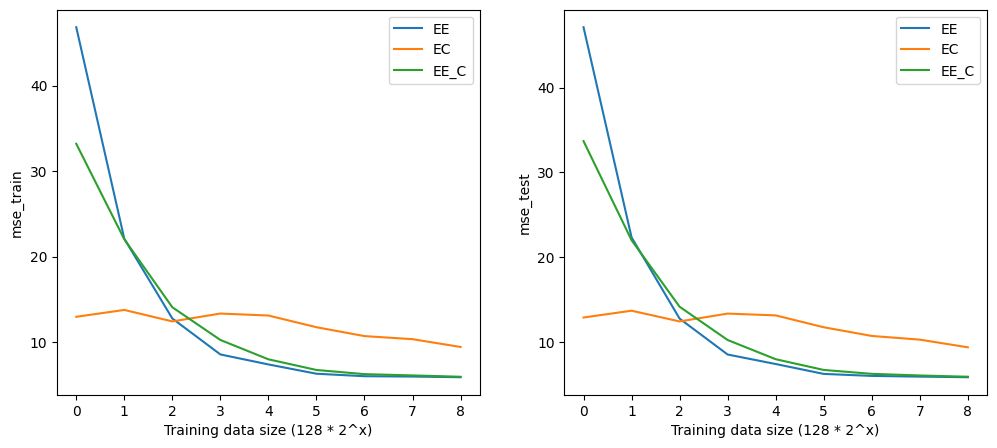

In [9]:
def plot_metric_curve(res_df, metrics):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(12,5))
    
    for i, metric in enumerate(metrics):
        for model_name in ['EE', 'EC', 'EE_C']:
            ax[i].plot(range(9), res_df.loc[res_df.model==model_name, metric], label=model_name)

            ax[i].set_ylabel(metric)
            ax[i].set_xlabel('Training data size (128 * 2^x)')
            ax[i].legend()

    plt.show()

metrics = ['mse_train', 'mse_test']
plot_metric_curve(avg_res_df, metrics)

* The models perform similarly in training and testing set, indicating no overfitting problems, as these trees only split once.

* EE and EC: When training data size is small, EE performs worse than EC, but as the amount of data increases, EE outperforms EC.

* EC and EE_C: Both have the same split, but different correction values. When the data size is small, the correction of EC is better than EE_C in terms of MSE. As the data volume increases, the correction of EE_C is better.

* EE and EE_C: Whe the data size is small, EE does not select the split that has the lowest MSE on the training set, due to the difference in the estimated MSE and actual MSE. Belows compares the impurity value (splitting criterion) of EE and EE_C model from the same training sample. EE always has smaller or equal impurity value than EE_C, indicating that the implementation of EE algorithm should be okay.


In [10]:
res_df = res_df.reset_index()
res_df = res_df.set_index(['seed', 'train_size'])
imp_ee = res_df.loc[res_df.model=='EE', 'impurity']
imp_ee_c = res_df.loc[res_df.model=='EE_C', 'impurity']

compares = (imp_ee < imp_ee_c) | ((imp_ee-imp_ee_c).abs()<=1e-9)
print(compares.all())

True


EE performs quite well in terms of causal impact as the amount of data increases. I think this may be due to the characteristics of the data taht lead to a high correlation between effect estimation and classification.

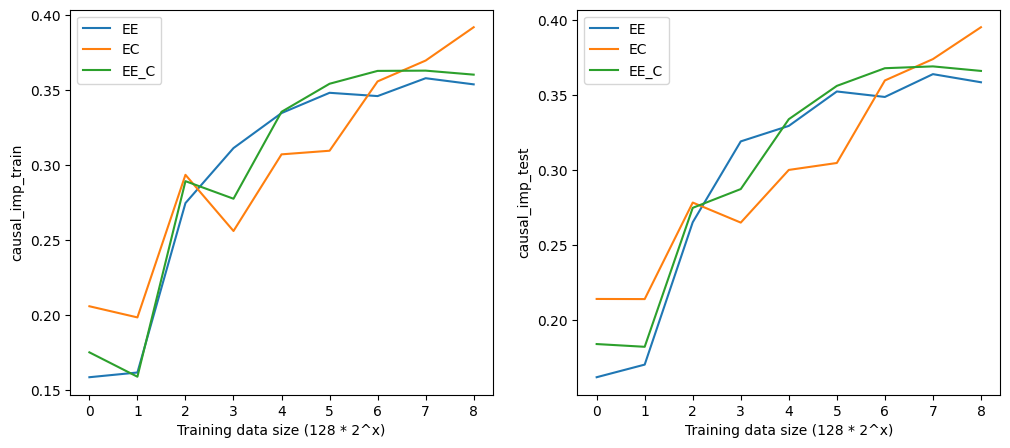

In [11]:
metrics = ['causal_imp_train', 'causal_imp_test']
plot_metric_curve(avg_res_df, metrics)

Regarding why EC can reduce MSE to a small value with a small data size, I think it is mainly about the data.

Runtime=17.08183 seconds
Kendal rank correlation between confouded CATE and actual CATE: 0.66173


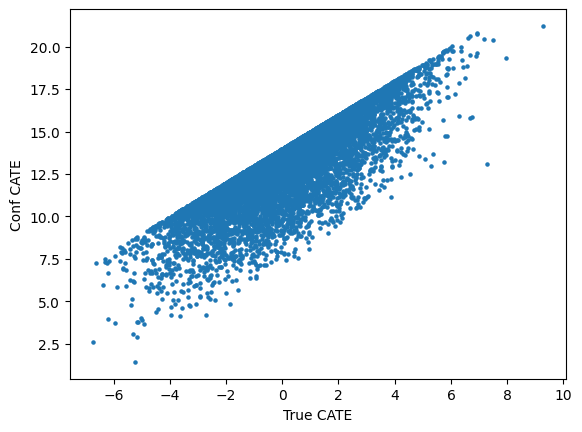

In [12]:
X, t, y, c, y0, _ = dg.generate_data(10000, is_exp=False)

start = time()

bias = dg.estimate_bias(X, n_per_x=5000) 
c_est = c + bias

plt.scatter(c, c_est, s=5)
plt.xlabel('True CATE')
plt.ylabel('Conf CATE')

corr = kendalltau(c_est, c)[0]
print(f"Runtime={(time()-start):.5f} seconds")
print(f"Kendal rank correlation between confouded CATE and actual CATE: {corr:.5f}")

The distribution of c_est has a shift compared to c, but their distribution shapes are still similar. Given such data, it appears that EC may easily reduce the MSE by a large amount with just a small data.

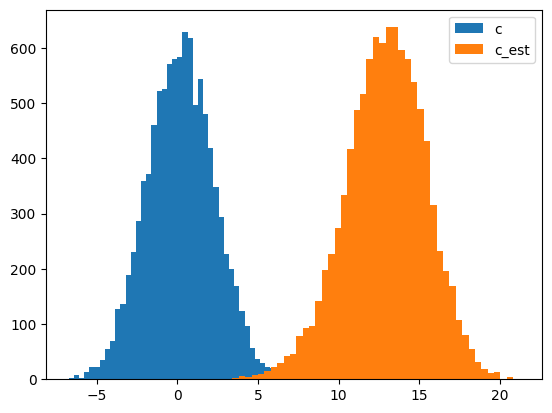

In [13]:
_ = plt.hist(c, bins=50, label='c')
_ = plt.hist(c_est, bins=50, label='c_est')
plt.legend()
plt.show()

I changed the relationship between treatment probability and u from linear to quadractic, making things complicated.

In [14]:
dg_1 = DataGenerator(
        n_features=50, 
        alpha_0=50.0,
        theta=0.3,
        avg_cate=0.1,
        noise_scale_c=0.1,
        noise_scale_y0=1.0,
        noise_scale_a=1.0,
        treatment_type='quad'
)

dg_1.beta = dg.beta
dg_1.beta_0 = dg.beta_0
dg_1.alpha = dg.alpha

Runtime=18.49503 seconds
Kendal rank correlation between confouded CATE and actual CATE: 0.21898


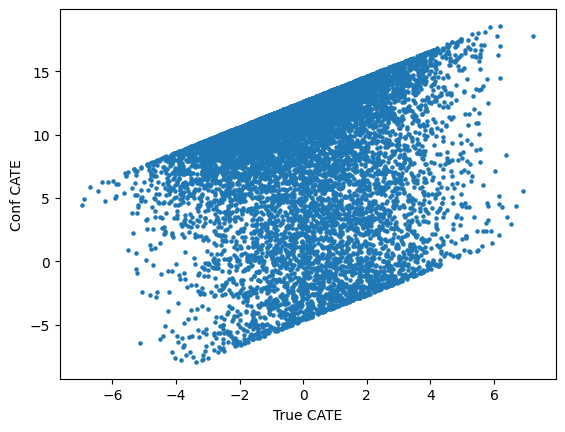

In [15]:
X, t, y, c, y0, _ = dg_1.generate_data(10000, is_exp=False)

start = time()

bias = dg_1.estimate_bias(X, n_per_x=5000) 
c_est = c + bias

plt.scatter(c, c_est, s=5)
plt.xlabel('True CATE')
plt.ylabel('Conf CATE')

corr = kendalltau(c_est, c)[0]
print(f"Runtime={(time()-start):.5f} seconds")
print(f"Kendal rank correlation between confouded CATE and actual CATE: {corr:.5f}")

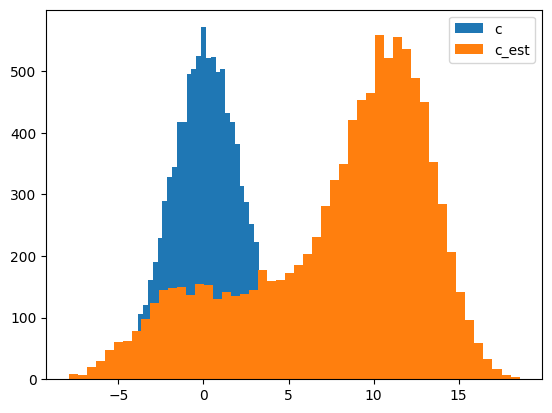

In [16]:
_ = plt.hist(c, bins=50, label='c')
_ = plt.hist(c_est, bins=50, label='c_est')
plt.legend()
plt.show()

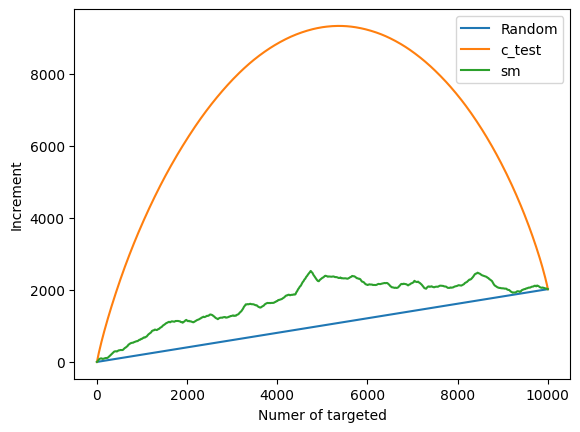

In [17]:
sm_1 = scoring_model(dg_1, n=50000)

scores_dict = {'c_test': c_test, 'sm': sm_1.predict(X_test)}
plot_uplift_curves(c_test, scores_dict)

In [18]:
start = time()
res_1 = []
train_size_grid = [128*(2**i) for i in range(9)]

scores_test = sm.predict(X_test)

for seed in range(50):
    np.random.seed(seed)
    for i, train_size in enumerate(train_size_grid):
        res_i = run_single_experiment(dg_1, sm_1, train_size, X_test, t_test, y_test, scores_test, c_test, seed)
        res_1 += res_i

res_df_1 = pd.DataFrame(res_1)
avg_res_df_1 = res_df_1.groupby(by=['model', 'train_size']).mean().reset_index()

print(f"Runtime = {(time()-start):.5f} s")

Runtime = 77.22022 s


Below plots show that EC and EE are not able to work well in terms of MSE and causal impact respectively.

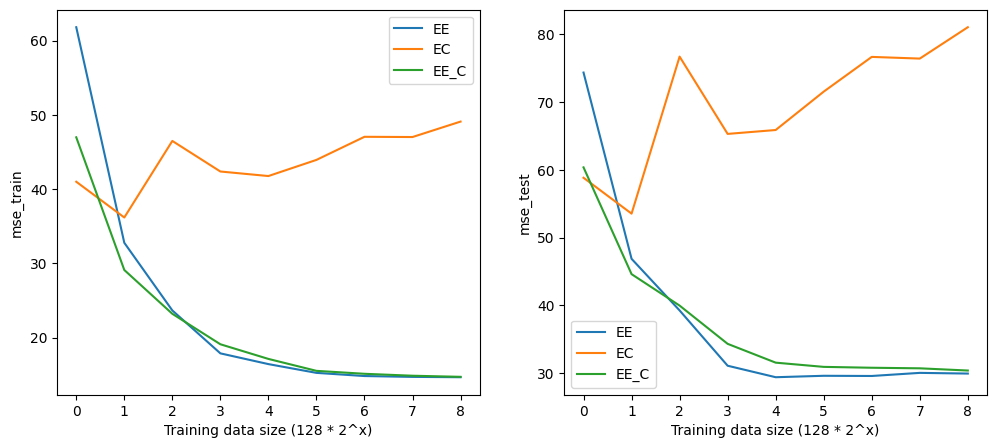

In [19]:
metrics = ['mse_train', 'mse_test']
plot_metric_curve(avg_res_df_1, metrics)

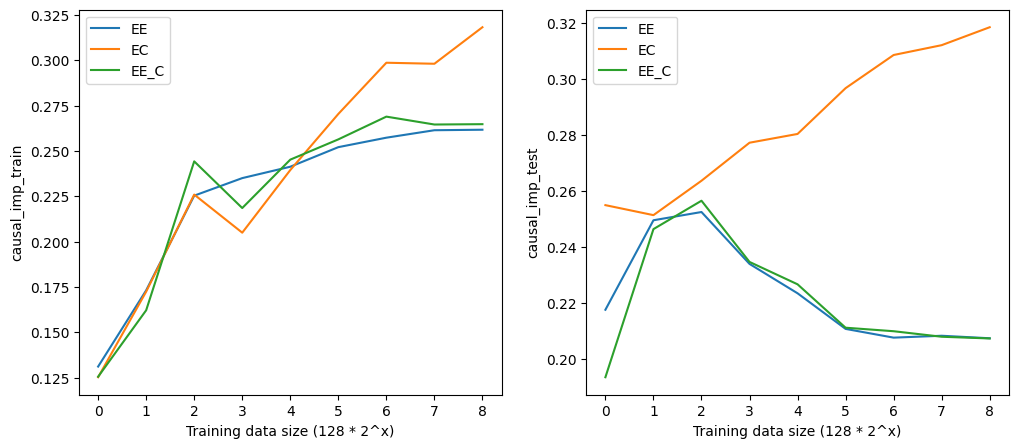

In [20]:
metrics = ['causal_imp_train', 'causal_imp_test']
plot_metric_curve(avg_res_df_1, metrics)